# A pedagogical example of fine-mapping problem

Here we demonstrate with simulated data a setting that for fine-mapping problem it is problematic to run step-wise conditional analysis, but SuSiE's variational procedure can correctly identify the causal signals. We also compared SuSiE results with other Bayesian sparse regression approach, and demonstrate that SuSiE is robust to prior choice and provide information more relevant to fine mapping applications that other methods do not provide.

From simulated data we pick this case example where the top z-score might be a result of two adjecent clusters of non-zero effects. See [here](https://stephenslab.github.io/susieR/articles/finemapping.html) for a brief description on simulation.

In [1]:
%revisions -s -n 10

Revision,Author,Date,Message
35d8987,Gao Wang,2018-11-19,Simplified SuSiE main interface
8f72a6e,Gao Wang,2018-10-26,Update notebook
77f1af1,Gao Wang,2018-09-11,Improve documentation
e003f91,Gao Wang,2018-09-11,Add CAVIAR and FINEMAP with larger priors
9c3656c,Gao Wang,2018-09-11,Add an example using very small SuSiE prior
4c7eed4,Gao Wang,2018-08-21,Change code to use v0.3 interface
1c352db,Gao Wang,2018-08-21,Update notebook description
25944c8,Gao Wang,2018-08-21,SuSiE v0.3 results
7eb74ec,Gao Wang,2018-08-21,Improve notebook description
c322825,Gao Wang,2018-08-21,susieR v0.1 ROC and PIP calibration


In [2]:
library(susieR)
set.seed(1)

In [3]:
data("N2finemapping")
attach(N2finemapping)

In [4]:
dat = N2finemapping
names(dat)

[1] "X"                 "chrom"             "pos"              
[4] "true_coef"         "residual_variance" "Y"                
[7] "allele_freq"       "V"

This simulated data-set has two replicates. We focus on the fist replicate:

In [5]:
r = 1

## Comparing SuSiE with per-variable regression

We fit SuSiE and obtain its CS and PIP. We also perform a per-feature simple regression and get (asymptotic) z-scores by setting `compute_univariate_zscore` to `TRUE`.

In [6]:
fitted = susie(dat$X, dat$Y[,r], L=5,
               estimate_residual_variance=TRUE, 
               scaled_prior_variance=0.2,
               tol=1e-3, track_fit=TRUE,
               compute_univariate_zscore=TRUE,
               coverage = 0.95, min_abs_corr = 0.1)

We plot p-values from per-feature regression in parallel with PIP from SuSiE. 

In [7]:
b = dat$true_coef[,r]
b[which(b!=0)] = 1
#susie_label = paste('SuSiE', length(sets$cs), 'CS identified')
susie_label = "SuSiE fit from IBFS"
pdf('susie_demo.pdf', width =10, height = 5, pointsize=16)
par(mfrow=c(1,2))
susie_plot(fitted, y='z', b=b, max_cs=1, main = 'Marginal associations')
susie_plot(fitted, y='PIP', b=b, max_cs=0.4, main = susie_label, add_legend = TRUE)
dev.off()

png 
  2

%preview susie_demo.pdf

> susie_demo.pdf (15.6 KiB):

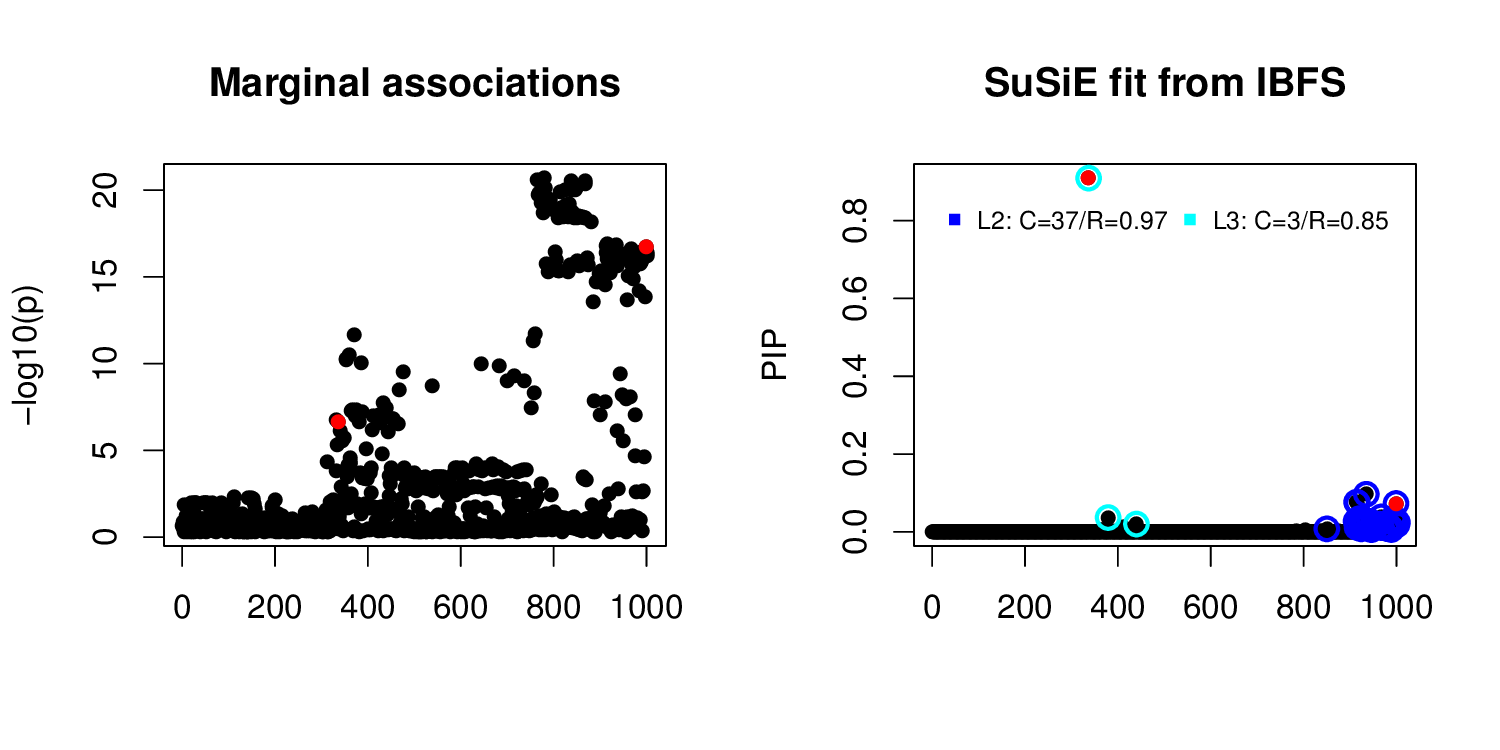

In [8]:
%preview susie_demo.pdf -s png --dpi 150

The identified CS are:

In [10]:
print(fitted$sets$cs)

$L2
 [1]  850  913  914  915  916  920  924  925  926  927  930  931  933  934  935
[16]  942  946  948  951  952  962  967  968  979  980  982  983  985  988  989
[31]  993  994  996  999 1000 1001 1002

$L3
[1] 337 379 440



`L2` corresponds to the blue cluster around position 900. `L3` corresponds to the cyan cluster around position 400. In both cases the simulated non-zero effect are captured by the confidence sets.

The CS `L2` has many variables. We check how correlated they are:

In [11]:
fitted$sets$purity

,min.abs.corr,mean.abs.corr,median.abs.corr
L2,0.9722386,0.9939738,0.9949722
L3,0.8534981,0.9183993,0.8944609


The minimum absolute correlation is 0.97 for CS `L2`. So SuSiE behavior is reasonable.

## Looking into SuSiE VEM iterations

It takes 23 iterations for SuSiE to converge on this example. With `track_fit=TRUE` we keep in `fitted$trace` object various quantities to help with diagnotics.

In [12]:
fitted$niter

[1] 23

In [13]:
susie_plot_iteration(fitted, 3, 'demo')

Creating GIF animation ...
Iterplot saved to demo.gif


%preview demo.gif

> demo.gif (205.8 KiB):

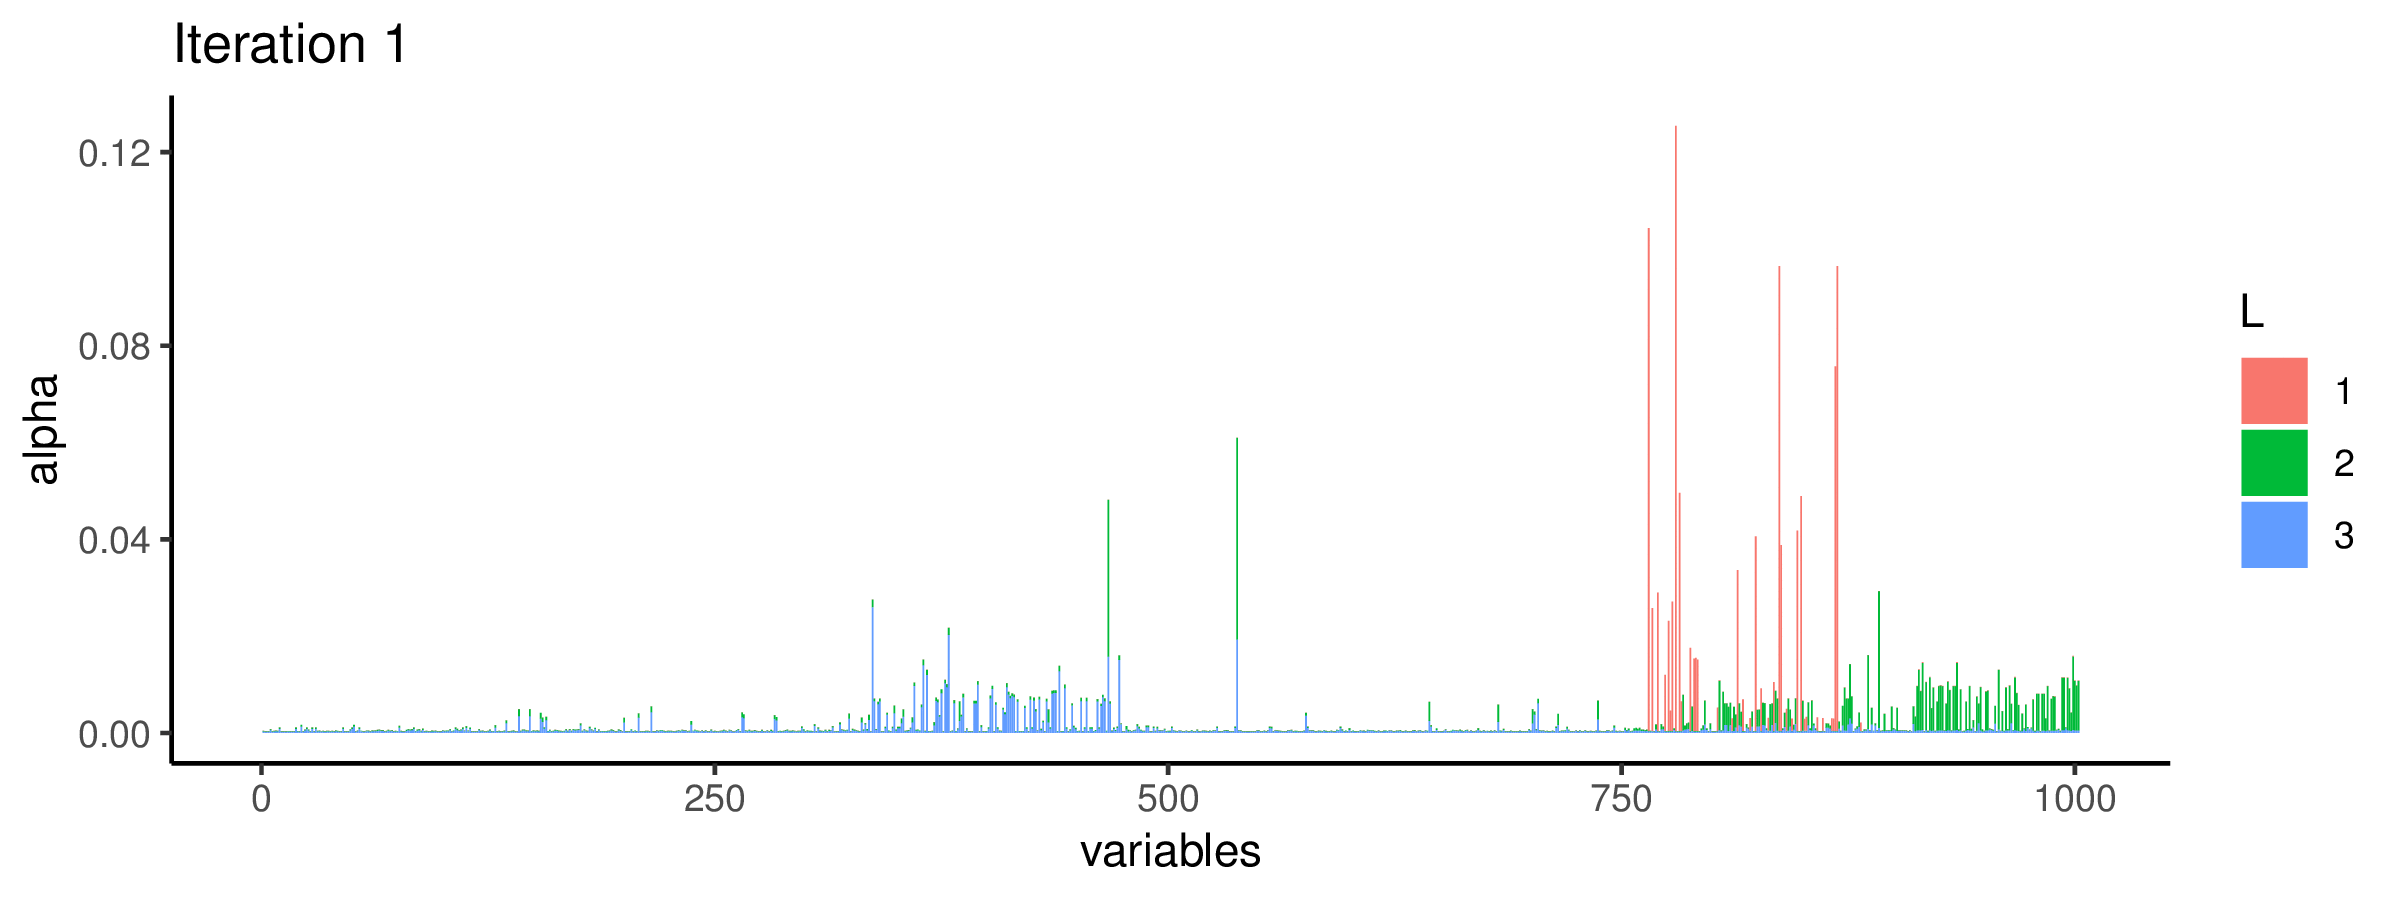

In [14]:
%preview demo.gif --width 80%

At the first iteration, the variable with the top z-score was picked up by the first CS. But in later iterations, the first CS vanishes; the 2nd and 3rd CS correctly pick up the two "true" signals.

## SuSiE with `L=2`

We now set `L=2` and see how SuSiE converges to the true signals, if capable:

In [16]:
fitted = susie(dat$X, dat$Y[,r], L=2,
               estimate_residual_variance=TRUE, 
               scaled_prior_variance=0.2,
               tol=1e-3, track_fit=TRUE,
               coverage = 0.95,min_abs_corr = 0.1)
pdf('l2.pdf', width =5, height = 5, pointsize=16)
susie_plot(fitted, y='PIP', b=b, max_cs=0.4, main = paste('SuSiE', length(fitted$sets$cs), 'CS identified'))
dev.off()

png 
  2

%preview l2.pdf

> l2.pdf (8.6 KiB):

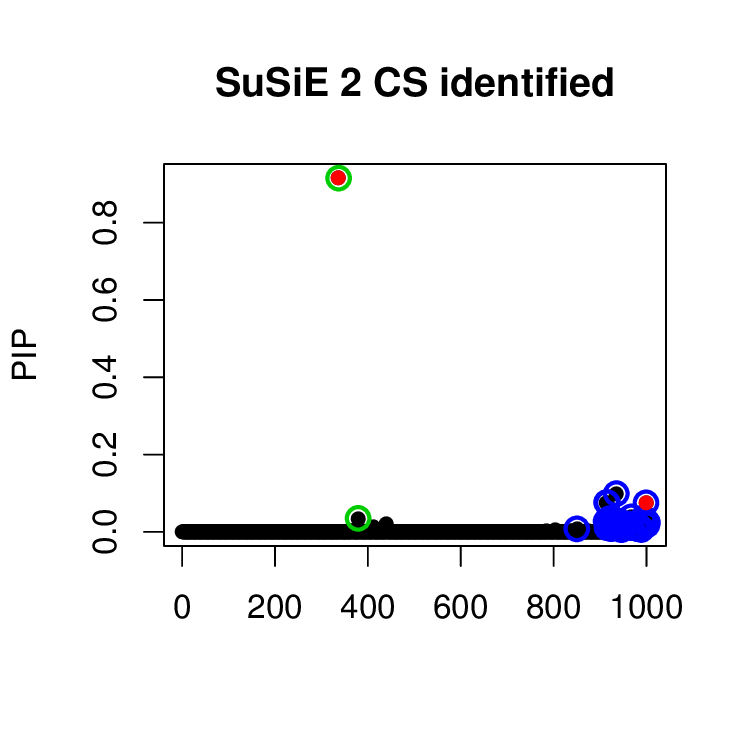

In [17]:
%preview l2.pdf -s png --dpi 150

In [18]:
fitted$niter

[1] 10

In [19]:
susie_plot_iteration(fitted, 2, 'demo_l2')

Creating GIF animation ...
Iterplot saved to demo_l2.gif


%preview demo_l2.gif

> demo_l2.gif (150.8 KiB):

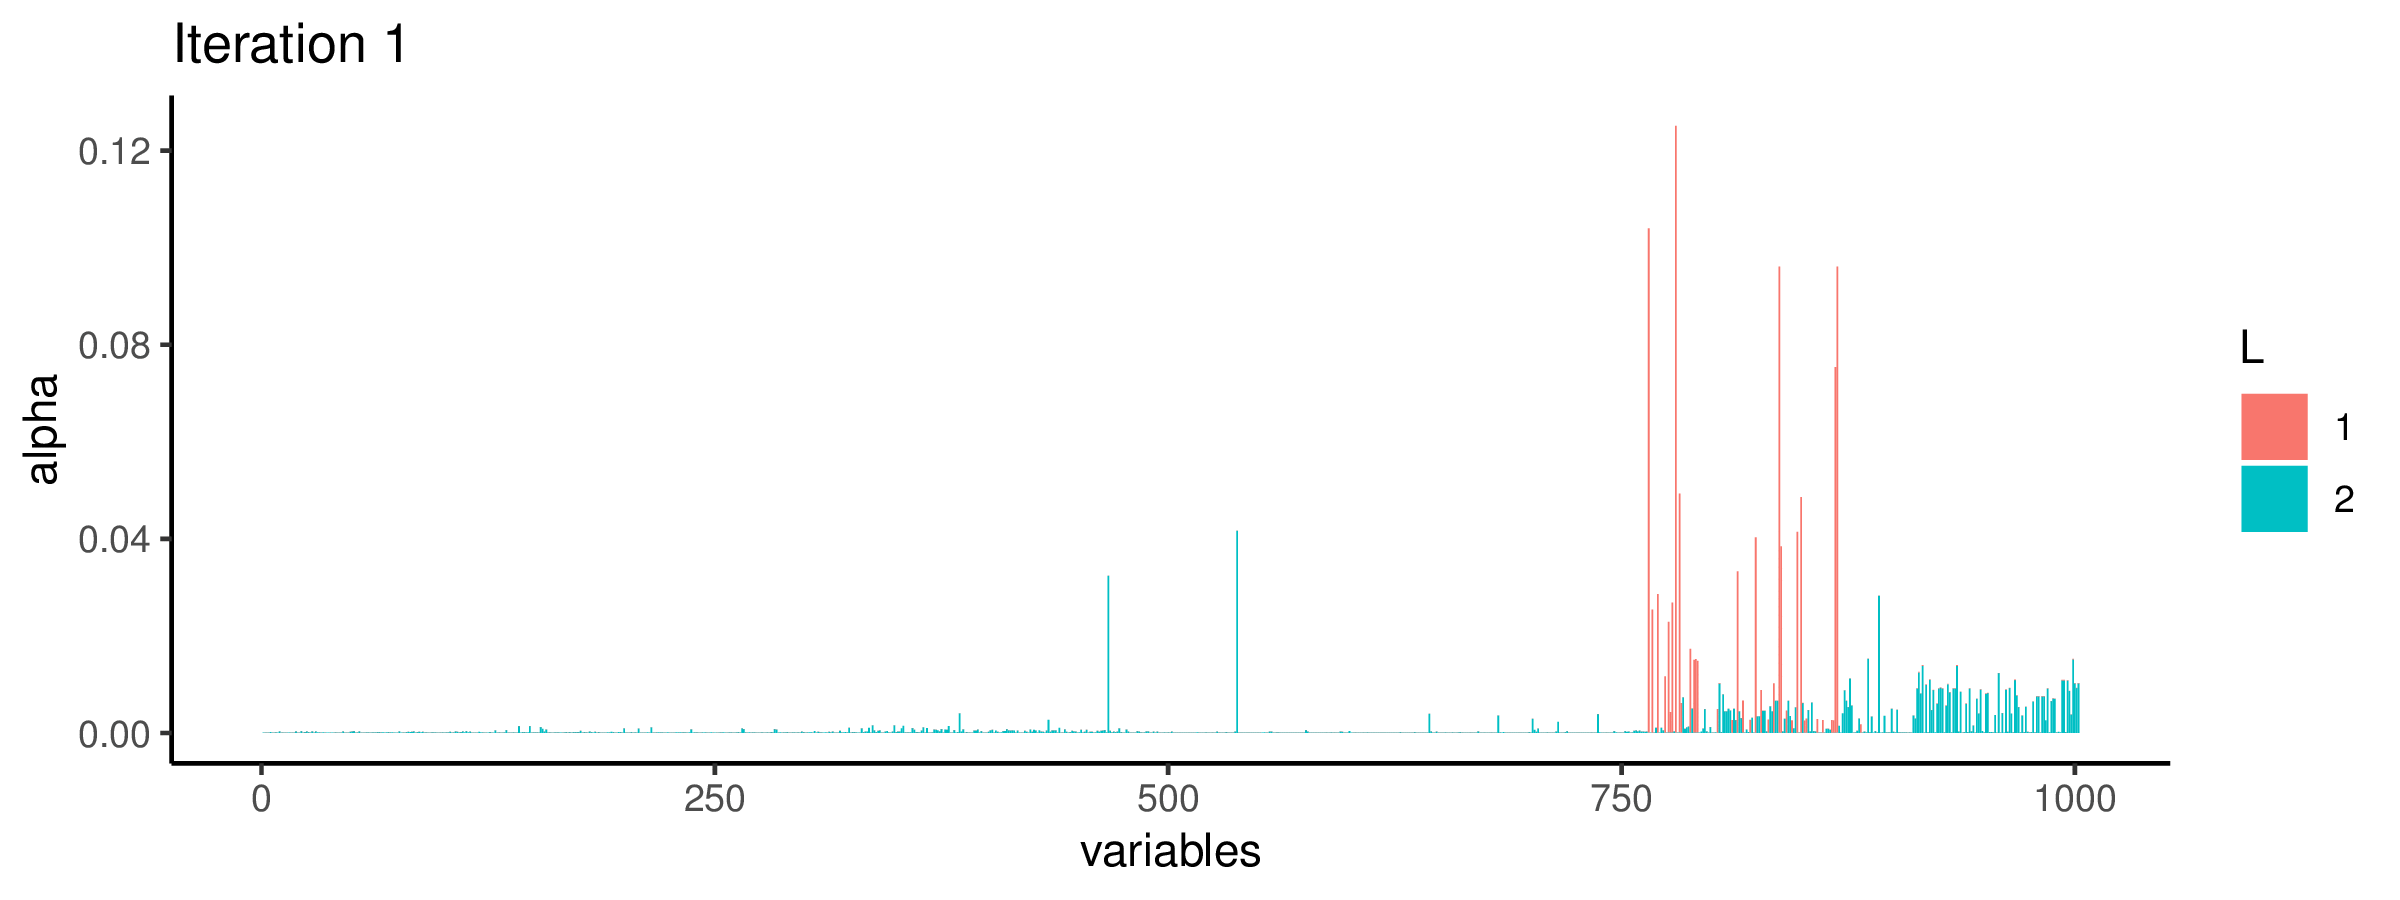

In [20]:
%preview demo_l2.gif --width 80%

It seems at the first iteration, the first CS picks up the induced wrong signal cluster, but both true signals were picked up by the 2nd CS which is quite wide. Later iterations removed the induced wrong cluster and the 2 CS properly converged to the two true signals as desired.

## Is the result robust to prior choice?
Here instead of fixing prior, I ask SuSiE to update prior variance

In [21]:
fitted = susie(dat$X, dat$Y[,r], L=5,
               estimate_residual_variance=TRUE, 
               estimate_prior_variance=TRUE,
               tol=1e-3, track_fit=TRUE,
               coverage = 0.95,
               min_abs_corr = 0.1)

In [22]:
pdf('est_prior.pdf', width =5, height = 5, pointsize=16)
susie_plot(fitted, y='PIP', b=b, max_cs=0.4, main = paste('SuSiE', length(fitted$sets$cs), 'CS identified'))
dev.off()

png 
  2

%preview est_prior.pdf

> est_prior.pdf (8.6 KiB):

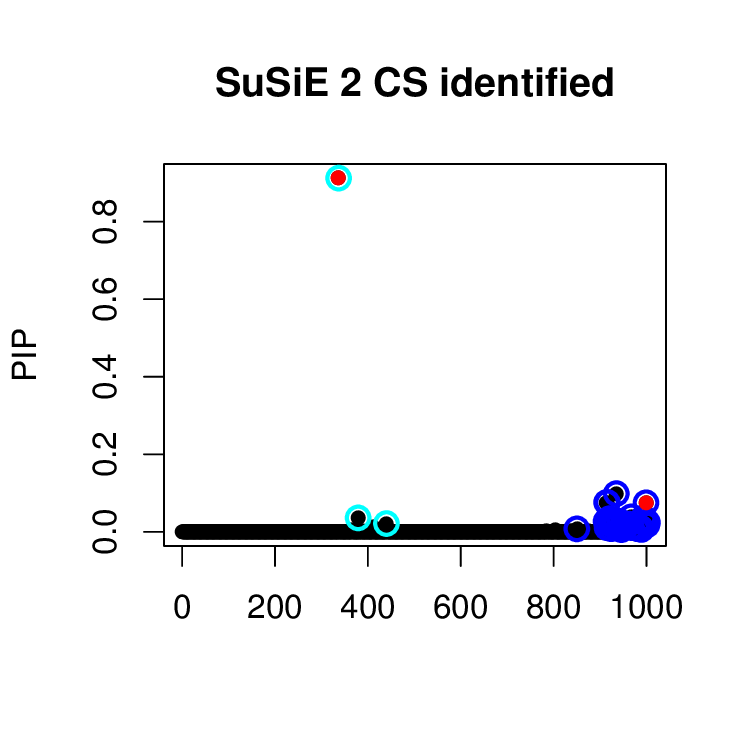

In [23]:
%preview est_prior.pdf -s png --dpi 150

Now I fix SuSiE prior to a smaller value (scaled prior is 0.005):

In [24]:
fitted = susie(dat$X, dat$Y[,r], L=5,
               scaled_prior_variance=0.005, 
               estimate_prior_variance=TRUE,
               tol=1e-3, track_fit=TRUE,
               coverage = 0.95,
               min_abs_corr = 0.1)

In [25]:
pdf('small_prior.pdf', width =5, height = 5, pointsize=16)
susie_plot(fitted, y='PIP', b=b, max_cs=0.4, main = paste('SuSiE', length(fitted$sets$cs), 'CS identified'))
dev.off()

png 
  2

%preview small_prior.pdf

> small_prior.pdf (8.6 KiB):

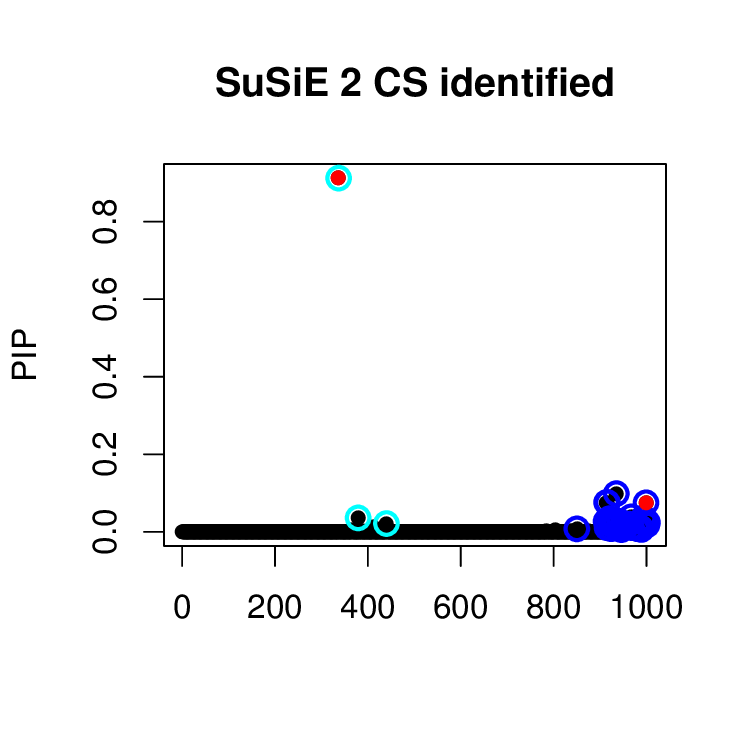

In [26]:
%preview small_prior.pdf -s png --dpi 150

Result remains largely the same.

## How other methods cope with this

In [this folder](https://github.com/stephenslab/susieR/tree/master/inst/code) we provide scripts to run `CAVIAR`, `FINEMAP` (version 1.1) and `DAP-G` on the same data-set for a comparison. We generate summary statistics and run these 3 other methods on the example.

In [27]:
library(abind)
mm_regression = function(X, Y, Z=NULL) {
  if (!is.null(Z)) {
      Z = as.matrix(Z)
  }
  reg = lapply(seq_len(ncol(Y)), function (i) simplify2array(susieR:::univariate_regression(X, Y[,i], Z)))
  reg = do.call(abind, c(reg, list(along=0)))
  # return array: out[1,,] is betahat, out[2,,] is shat
  return(aperm(reg, c(3,2,1)))
}
sumstats = mm_regression(as.matrix(dat$X), as.matrix(dat$Y))
saveRDS(list(data=dat, sumstats=sumstats), 'N2.with_sumstats.rds')

In [28]:
export PATH=~/GIT/github/mvarbvs/dsc/modules/linux:$PATH
Rscript ~/GIT/susieR/inst/code/finemap.R input=\"N2.with_sumstats.rds\" output=\"N2finemapping.FINEMAP\" args=\"--n-causal-max\ 2\" &> /dev/null

In [29]:
export PATH=~/GIT/github/mvarbvs/dsc/modules/linux:$PATH
Rscript ~/GIT/susieR/inst/code/caviar.R input=\"N2.with_sumstats.rds\" output=\"N2finemapping.CAVIAR\" args=\"-c\ 2\ -g\ 0.01\" &> /dev/null

In [30]:
export PATH=~/GIT/github/mvarbvs/dsc/modules/linux:$PATH
python ~/GIT/susieR/inst/code/dap-g.py N2.with_sumstats.rds N2finemapping.DAP -ld_control 0.20 --all &> /dev/null

Now we look at these results.

In [32]:
caviar = readRDS("N2finemapping.CAVIAR.rds")
finemap = readRDS("N2finemapping.FINEMAP.rds")
dap = readRDS("N2finemapping.DAP.rds")

### `CAVIAR` results

#### PIP

In [33]:
snp = caviar[[1]]$snp
pip = snp[order(as.numeric(snp$snp)),]$snp_prob
pdf('caviar_fm.pdf', width =5, height = 5, pointsize=16)
susie_plot(pip, y='PIP', b=b, main = 'CAVIAR')
dev.off()

png 
  2

%preview caviar_fm.pdf

> caviar_fm.pdf (8.9 KiB):

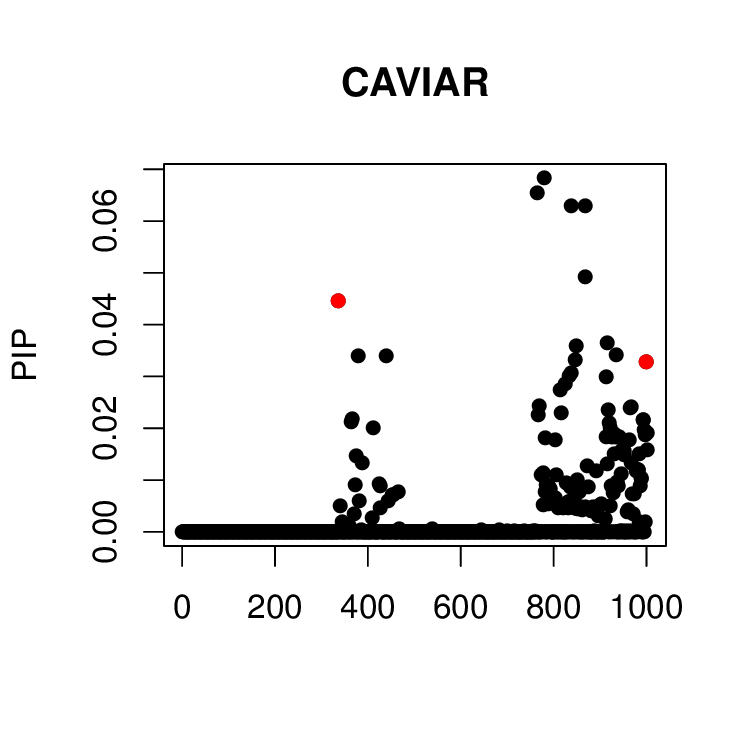

In [34]:
%preview caviar_fm.pdf -s png --dpi 150

#### 95% CS

CAVIAR provides single 95% confidence sets as follows:

In [35]:
print(caviar[[1]]$set)

  [1] "780"  "765"  "837"  "869"  "868"  "337"  "916"  "849"  "935"  "379" 
 [11] "440"  "847"  "999"  "838"  "834"  "914"  "824"  "814"  "770"  "967" 
 [21] "964"  "918"  "817"  "767"  "367"  "993"  "994"  "365"  "920"  "922" 
 [31] "411"  "996"  "1000" "1002" "930"  "997"  "926"  "913"  "925"  "927" 
 [41] "933"  "934"  "942"  "782"  "962"  "804"  "948"  "1001" "952"  "985" 
 [51] "931"  "951"  "375"  "968"  "387"  "915"  "873"  "979"  "980"  "982" 
 [61] "983"  "892"  "977"  "778"  "946"  "806"  "774"  "776"  "988"  "989" 
 [71] "850"  "937"  "827"  "424"  "372"  "784"  "426"  "924"  "940"  "788" 
 [81] "987"  "836"  "842"  "874"  "791"  "790"  "792"  "783"  "855"  "465" 
 [91] "929"  "969"  "973"  "452"  "455"  "803"  "841"  "382"  "443"  "832" 
[101] "789"  "809"  "812"  "902"  "777"  "899"  "921"  "341" 


In [36]:
any(which(b>0) %in% caviar[[1]]$set)

[1] TRUE

It is a wide CS, although it does capture the causal SNPs. 

#### Choice of prior

When I set `CAVIAR` non-centrality parameter to 10 instead of the default 5.2, I do get an improved result,

%preview /tmp/CAVIAR.ncp.hack.png

> /tmp/CAVIAR.ncp.hack.png (30.4 KiB):

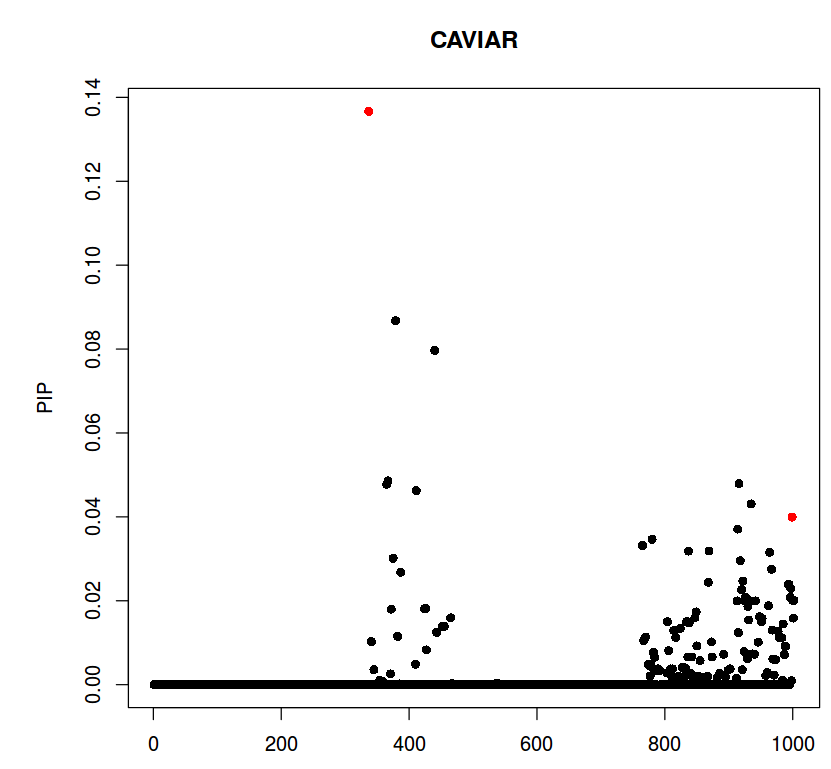

In [31]:
%preview /tmp/CAVIAR.ncp.hack.png

Analysis procedure not shown because `CAVIAR` by default does not allow configuration of NCP (need to change the code and re-compile the binary).

### `FINEMAP` results

#### PIP

In [37]:
snp = finemap[[1]]$snp
pip = snp[order(as.numeric(snp$snp)),]$snp_prob
pdf('finemap_fm.pdf', width =5, height = 5, pointsize=16)
susie_plot(pip, y='PIP', b=b, main = 'FINEMAP')
dev.off()

png 
  2

%preview finemap_fm.pdf

> finemap_fm.pdf (8.5 KiB):

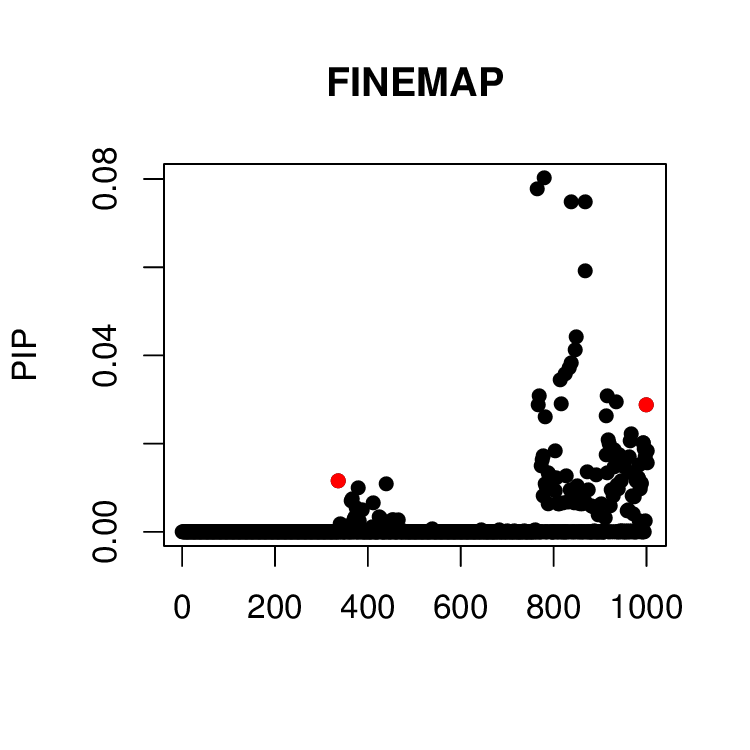

In [38]:
%preview finemap_fm.pdf -s png --dpi 150

#### 95% CS

For each configuration, FINEMAP provides the corresponding configuration probability:

In [39]:
head(finemap[[1]]$set, 10)

rank,config,config_prob,config_log10bf
1,"780,916",0.002430376,15.22015
2,"780,935",0.002337337,15.20320
3,"780,999",0.002332030,15.20221
4,"765,999",0.002209795,15.17883
5,"765,935",0.002208498,15.17858
6,"765,916",0.002171861,15.17131
7,"869,999",0.002134201,15.16371
8,"837,999",0.002134201,15.16371
9,"869,935",0.002133318,15.16353
10,"837,935",0.002133318,15.16353


It requires post-processing to come up with a single 95% set similar to that of CAVIAR with all 3 causal variables captured. The result from running `finemap.R` provided has been truncated to the minimum set of configurations having cumulative probability of 95%. But the top 10 configurations completely missed the causal signals.

#### Choice of prior

The default prior for `FINEMAP` is 0.05 (for the Gaussian standard deviation). Knowing from simulation parameters of the true effect size, we increase it to 0.1.

In [41]:
export PATH=~/GIT/github/mvarbvs/dsc/modules/linux:$PATH
Rscript ~/GIT/susieR/inst/code/finemap.R input=\"N2.with_sumstats.rds\" output=\"N2finemapping.FINEMAP.p1std\" args=\"--n-causal-max\ 2\ --prior-std\ 0.1\" &> /dev/null

In [42]:
finemap = readRDS("N2finemapping.FINEMAP.p1std.rds")
snp = finemap[[1]]$snp
pip = snp[order(as.numeric(snp$snp)),]$snp_prob
pdf('finemap_bigger_prior.pdf', width =5, height = 5, pointsize=16)
susie_plot(pip, y='PIP', b=b, main = 'FINEMAP')
dev.off()

png 
  2

%preview finemap_bigger_prior.pdf

> finemap_bigger_prior.pdf (8.3 KiB):

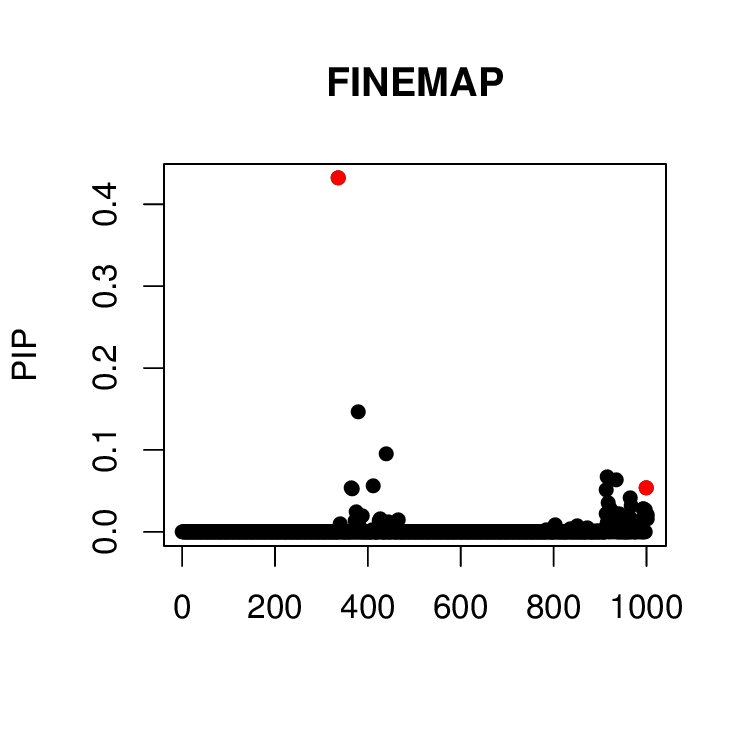

In [43]:
%preview finemap_bigger_prior.pdf -s png --dpi 150

In [44]:
head(finemap[[1]]$set, 10)

rank,config,config_prob,config_log10bf
1,"337,935",0.03342116,23.07379
2,"337,916",0.02894386,23.01132
3,"337,914",0.02700049,22.98114
4,"337,999",0.02604786,22.96554
5,"337,967",0.01653785,22.76824
6,"337,993",0.01418450,22.70158
7,"337,994",0.01418057,22.70146
8,"337,920",0.01353786,22.68131
9,"379,964",0.01352534,22.68091
10,"337,926",0.01225438,22.63806


The reported best configuration is closer to the true effects.

### `DAP-G` results

#### PIP

In [45]:
snp = dap[[1]]$snp
pip = snp[order(as.numeric(snp$snp)),]$snp_prob
pdf('dap_fm.pdf', width =5, height = 5, pointsize=16)
susie_plot(pip, y='PIP', b=b, main = 'DAP-G')
dev.off()

png 
  2

%preview dap_fm.pdf

> dap_fm.pdf (8.2 KiB):

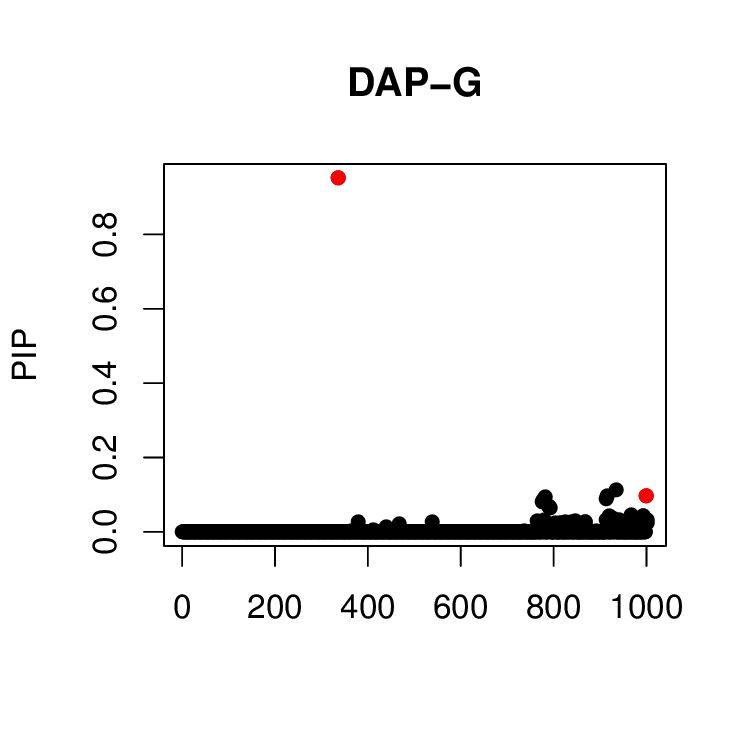

In [46]:
%preview dap_fm.pdf -s png --dpi 150

The default prior works

#### 95% CS

Similar to SuSiE, DAP-G provides per-signal 95% CS:

In [47]:
dap[[1]]$set

,cluster,cluster_prob,cluster_avg_r2,snp
0,1,1.000000,0.855,"782,778,776,788,790,791,792,780,765,847,869,837,868,824,849,817,838,834,770,814,767,803,783,774,827"
1,2,1.000000,0.966,"935,916,999,914,967,993,994,920,926,925,913,927,933,934,942,996,1002,1000,962,1001,930,985,804,892"
2,3,1.000000,0.821,"337,379,440,411,365,367"
3,4,0.055970,0.558,"538,467,947,737,965,911,956"
4,5,0.000072,1.000,157


Using an average $r^2$ filter of 0.2 ($r=0.44$, compared to SuSiE's $r=0.1$ in earlier analysis), it reports five 95% CS; the first 3 CS contain causal signals. Also the first CS is wider.